![title](../static/wcar.png)
#  Oocyst Wall Proteome

    Wellcome Centre for Anti-Infectives Research
    School of Life Sciences, University of Dundee

This notebook perform the data analysis and plots Fig X of the paper

In [1]:
import pathlib
#pathlib.Path().absolute()

In [2]:
#reload library if modified
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import utilities as PTUT
import pandas as pd
import seaborn as sns
import ProtRank
import matplotlib.pyplot as plt
import numpy as np

## Load and clean dataset


We analise protein/protein groups with a minimum of two unique peptide identified and andromada score > 5.

In [4]:
df = pd.read_csv('../in_data/proteinGroups.txt',sep='\t')
df = PTUT.clean_df(df, score=5, unique_pep_threshold=2)
df = PTUT.mod_df(df)
print(df.shape)
df.head()

starting from: (2303, 139)
removed  111 Protein Groups by: Only identified by site
tot  111  entries removed
---------------
removed  21 Protein Groups by: Reverse
tot  132  entries removed
---------------
removed  68 Protein Groups by: Potential contaminant
tot  200  entries removed
---------------
removed  287 Protein Groups by: Score
tot  487  entries removed
---------------
removed  36 Protein Groups by: Peptide counts (unique)
tot  523  entries removed
---------------
(1780, 142)


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Taxonomy IDs,unique_int,Gene_id,desc
0,A0A088QMV3;A0A3Q1MPS1,A0A088QMV3;A0A3Q1MPS1,5;3,5;3,5;3,tr|A0A088QMV3|A0A088QMV3_BOVIN 20beta-hydroxys...,2,5,5,5,...,9168;9471;9487;12550;24872,181148;181149;188168;188510;188511;188512;1885...,172073;172074;178611;178915;178916;178917;1789...,172074;178611;178918;234506;452006,0,178,-1;-1,5,A0A088QMV3,none
4,A0A140T871,A0A140T871,6,6,6,tr|A0A140T871|A0A140T871_BOVIN Glutamate dehyd...,1,6,6,6,...,892;8863;28915;33702;34844;35175,18708;18709;18710;18711;18712;174759;174760;55...,17124;17125;17126;165746;165747;524790;524791;...,17125;165746;524790;625967;644898;650486,1,229,-1,6,A0A140T871,none
6,A0A3Q1LKF4;A0A140T896,A0A3Q1LKF4;A0A140T896,3;3,3;3,3;3,tr|A0A3Q1LKF4|A0A3Q1LKF4_BOVIN Serine hydroxym...,2,3,3,3,...,580;884;17061,11727;11728;11729;11730;11731;11732;11733;1864...,10727;10728;10729;10730;10731;17066;17067;3103...,10728;17066;310397,3;4,256;333,-1;-1,3,A0A3Q1LKF4,none
8,A0A140T8A5,A0A140T8A5,7,7,7,tr|A0A140T8A5|A0A140T8A5_BOVIN Isocitrate dehy...,1,7,7,7,...,1700;9814;10391;16930;19546;21729;30904,35236;35237;35238;194732;194733;206986;206987;...,32523;184686;184687;196184;196185;308189;35591...,32523;184687;196185;308189;355910;394584;565986,8;9,254;259,-1,7,A0A140T8A5,none
10,A0A140T8B6;A0A3Q1LVK7;A0A3Q1LRG4;A0A3Q1LV22,A0A140T8B6,12;3;3;3,3;0;0;0,2;0;0;0,"tr|A0A140T8B6|A0A140T8B6_BOVIN Keratin, type I...",4,12,3,2,...,1518;2492;5799;6356;6357;9460;15660;15877;1619...,31901;31902;31903;31904;31905;31906;31907;3190...,29449;29450;29451;29452;29453;29454;29455;2945...,29460;50871;110655;117332;178500;286162;291314...,12;13,101;355,-1;-1;-1;-1,2,A0A140T8B6,none


In [5]:
#remove cow proteins
print(df.shape)
print('Removing protein with high homology to Cow proteins')
df = df[[False if 'tr|' in n else True for n in df['Fasta headers']]]
print(df.shape)

(1780, 142)
Removing protein with high homology to Cow proteins
(1661, 142)


In [6]:
#creata a protein desc dictionary
desc_dict = dict(zip(df['Gene_id'], df['desc']))

## Extract Intensity Values
Let's have a look at the intensity values

In [7]:
#color palette
palette=['b','b','b','r','r','r']
palette_g = ['r','b']
color_dictionary = { 'b':'SPORO','r':'WALL',}

In [8]:
#list(df.columns)

In [9]:
#tag ='Intensity'
tag ='iBAQ'
#tag ='LFQ intensity'
cols=[' SPORO_1',' SPORO_2',' SPORO_3', ' WALL_1', ' WALL_2',' WALL_3']
cols = [tag+n for n in cols]
selection = df[cols]
selection.columns = [n.split(' ')[-1] for n in cols]
print(selection.shape)
selection = selection[(selection.T != 0).any()]
print(selection.shape)

#selection.rename({'PULL':'POOL'},axis=1,inplace=True)
#selection.describe()

(1661, 6)
(1659, 6)


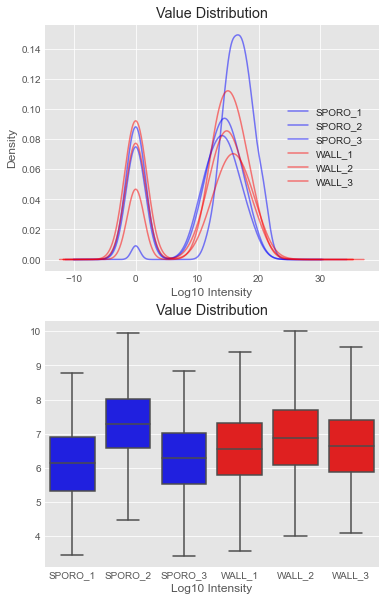

In [10]:
plt.style.use('ggplot')
fig,axes=plt.subplots(ncols=1,nrows=2,figsize=(6,10))

np.log1p(selection).plot(kind='kde', color=palette, alpha=0.5,ax=axes[0])
axes[0].legend(loc='center left', bbox_to_anchor=(0.7, 0.5))
axes[0].set_title('Value Distribution')
axes[0].set_xlabel('Log10 Intensity')

sns.boxplot(data =np.log10(selection.replace(0,np.nan)),
            showfliers=False,palette=palette,ax=axes[1])
plt.title('Value Distribution')
plt.xlabel('Log10 Intensity')
plt.savefig(os.path.join('../out_data/value_distribution.png'))
plt.show()

## Missing Data Analysis


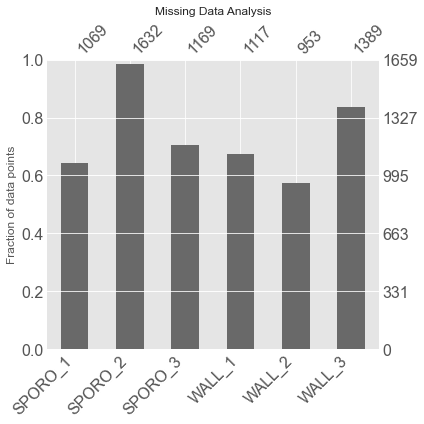

In [11]:
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
#visualization of missing data
ax=msno.bar(selection.replace(0,np.nan),figsize=(6, 6))
plt.title('Missing Data Analysis',size=12)
ax.set_ylabel('Fraction of data points',size=12)
plt.tight_layout()
plt.savefig('../out_data/missing.png')
plt.show()

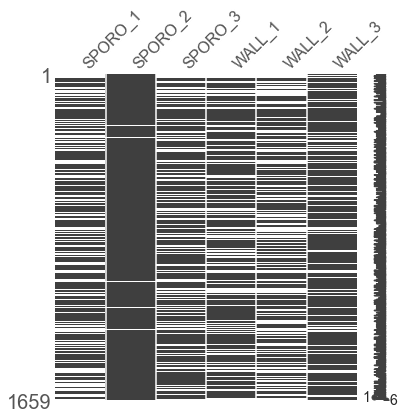

In [12]:
#print(data.shape)
msno.matrix(selection.replace(0,np.nan), figsize=(6, 6))
plt.show()

## PCA analysis

[0.57716503 0.20690685]
{'b': 'SPORO', 'r': 'WALL'}


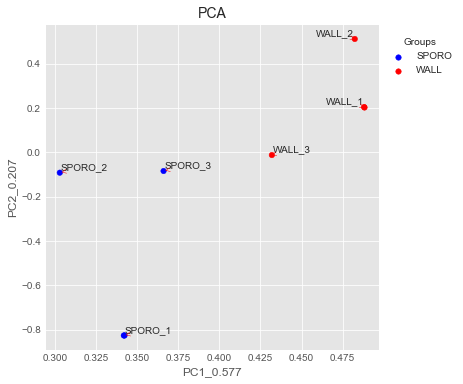

In [13]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize = (6,6))
PTUT.make_pca(np.log10(selection.replace(0,np.nan).dropna()),
              palette=palette,ax=ax,do_adjust_text=True,top=200,
             color_dictionary =color_dictionary)
plt.show()

## Proteins Group Identified only in one conditions

In [14]:
sporo_nan_1 = selection[['SPORO_1','SPORO_2','SPORO_3']].replace(0,np.nan).isna().sum(axis=1)
wall_nan_1  = selection[['WALL_1','WALL_2','WALL_3']].replace(0,np.nan).isna().sum(axis=1)
only_wall_1 = selection[(sporo_nan_1==3) & (wall_nan_1<3)]
only_sporo_1 = selection[(sporo_nan_1<3) & (wall_nan_1==3)]
print(' Found only in Wall:',only_wall_1.shape[0],'\n',
      'Found only in Sporo:',only_sporo_1.shape[0])

 Found only in Wall: 26 
 Found only in Sporo: 151


## Coefficent of variation

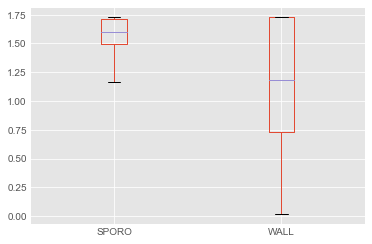

In [15]:
def get_cv(data):
    mean = data.mean(axis=1)
    #print(mean)
    std = data.std(axis=1)
    #print(std)
    cv = std/mean
    #print(cv)
    return cv

cvs = []
for group in [
    ['SPORO_1', 'SPORO_2', 'SPORO_3'],
    ['WALL_1', 'WALL_2', 'WALL_3']]:
    
    data = selection[group]
    cvs.append(get_cv(data))
    
    
cvs = pd.concat(cvs,axis=1)
cvs.columns = ['SPORO','WALL']
cvs.plot(kind='box',showfliers=False)

## Differential Abundance Analysis - ProtRank

In [16]:
#selection

In [17]:
indata_prank = selection.copy()
indata_prank.head()

,SPORO_1,SPORO_2,SPORO_3,WALL_1,WALL_2,WALL_3
193,509040.0,15115000.0,81057.0,108020.0,52859.0,526270.0
194,2629300.0,33530000.0,1872100.0,1636300.0,0.0,3833200.0
195,0.0,2466100.0,0.0,0.0,0.0,634440.0
196,223840.0,5111700.0,0.0,1276900.0,0.0,4878100.0
197,521440.0,24313000.0,2029700.0,3396200.0,733360.0,6510300.0


In [18]:
#indata_prank = selection[['SPORO1', 'SPORO2', 'SPORO3',  'WALL1', 'WALL2', 'WALL3']]
#indata_prank=indata_prank.replace(0,np.nan)
#indata_prank=indata_prank.fillna(indata_prank.min())
indata_prank=indata_prank.join(df[['Gene_id']],how='left')
indata_prank.set_index('Gene_id',drop=True,inplace=True)
indata_prank.to_csv('../out_data/out_ProtRank.csv')
indata_prank.head()

,SPORO_1,SPORO_2,SPORO_3,WALL_1,WALL_2,WALL_3
Gene_id,,,,,,
cgd1_1060-RA-p1,509040.0,15115000.0,81057.0,108020.0,52859.0,526270.0
cgd1_1080-RA-p1,2629300.0,33530000.0,1872100.0,1636300.0,0.0,3833200.0
cgd1_110-RA-p1,0.0,2466100.0,0.0,0.0,0.0,634440.0
cgd1_1110-RA-p1,223840.0,5111700.0,0.0,1276900.0,0.0,4878100.0
cgd1_1140-RA-p1,521440.0,24313000.0,2029700.0,3396200.0,733360.0,6510300.0


In [19]:
what_to_compare = [[['SPORO_1', 'WALL_1' ], ['SPORO_2', 'WALL_2'], ['SPORO_3', 'WALL_3' ]]]
ProtRank.data_stats(indata_prank, what_to_compare = what_to_compare, ignore_missed = True)
description = 'SPORO_vs_WALL'
significant_proteins = ProtRank.rank_proteins(indata_prank, what_to_compare, description,
                                              path_to='../out_data/')


input data contain results for 1659 proteins and 6 different conditions
list of measured conditions: SPORO_1, SPORO_2, SPORO_3, WALL_1, WALL_2, WALL_3
in the data, 26.4% of all counts are zeros

basic statistics for the subset of the data corresponding to the provided comparisons:
6 comparisons provided: [[['SPORO_1', 'WALL_1'], ['SPORO_2', 'WALL_2'], ['SPORO_3', 'WALL_3']]]
after ignoring 0 rows with only zero counts, 1659 rows remain
in the analyzed data, 26.4% of all counts are zeros
median count is 4.71e+06 (computed over non-zero entries only)
ratio between the largest and the smallest non-zero count is 3.47e+07
ratio between the 90th and the 10th percentile non-zero count is 1.13e+03
statistics of irregular missing values:
  in total, there are 1555 comparisons involving a zero and a non-zero value (31.2% of all)
  out of 4977 comparisons, 347 involve a zero value and a non-zero exceeding 1.0 * median (7.0% of all)
  (the smaller the fraction, the smaller the problem with irregu

In [20]:
#get back the results from protrank
def parse_prank(fname='../out_data/prs-SPORO_vs_WALL.dat',desc_dict=desc_dict):
    temp_1 = pd.read_csv(os.path.join(fname),
                       sep='\t', comment='#', index_col=[1],
                       names=['id','rank','FDR','sign'])
    temp_1['log_FDR']=-np.log10(temp_1['FDR']+0.0009)
    temp_1['log_rank']=np.log10(temp_1['rank'])
    temp_1['srank']=[n*1 if a=='+' else n*-1 for n,a in zip(temp_1['rank'],temp_1['sign'])]
    temp_1['desc']=[desc_dict[n] for n in temp_1.index.values]
    #temp_1.plot(kind='scatter',x='srank',y='log_FDR',marker='.')
    #print(fname+'prank_outo.csv')
    temp_1.to_csv(fname+'_prank_out.csv')
    return temp_1

out_all = parse_prank()    

In [21]:
out_all.sort_values('rank',ascending=False).head(5)

,id,rank,FDR,sign,log_FDR,log_rank,srank,desc
cgd1_800-RA-p1,1,93.857207,0.01,+,1.962574,1.972468,93.857207,Protein disulfide isomerase
cgd7_5150-RA-p1,2,67.279057,0.04,+,1.388277,1.827880,67.279057,Chitin-binding type-2 domain containing protein
cgd6_4840-RA-p1,3,65.097189,0.04,+,1.388277,1.813562,65.097189,"Serine protease, subtilase family, signal peptide"
cgd6_2090-RA-p1,4,62.289538,0.04,+,1.388277,1.794415,62.289538,Growth factor receptor cysteine-rich domain co...
cgd4_3090-RA-p1,5,56.644123,0.04,+,1.388277,1.753155,56.644123,Oocyst wall protein 6


In [22]:
out_all['log_sum']=np.log10(indata_prank.mean(axis=1))
out_all['log_rank'] = [np.log10(n[0]) if n[1]=='+' else np.log10(n[0])*-1 
                       for n in zip(out_all['rank'],out_all['sign'])]


In [53]:
#the protein that have been localized
name_dict = {
'cgd6_2090-RA-p1':'COWP1',
'cgd7_1800-RA-p1':'COWP2',
'cgd4_670-RA-p1':'COWP3',
'cgd8_3350-RA-p1':'COWP4',
'cgd7_5150-RA-p1':'COWP5',
'cgd4_3090-RA-p1':'COWP6',
'cgd4_500-RA-p1':'COWP7',
'cgd6_200-RA-p1':'COWP8',
'cgd6_210-RA-p1':'COWP9',
'cgd7_3120-RA-p1':'TPP',
'cgd7_4810-RA-p1':'Fibro',  
'cgd6_2470-RA-p1':'SOX',
'cgd3_3430-RA-p1':'AO2',   
'cgd2_790-RA-p1':'CCP3',
#'cgd8_4830-RA-p1':'Kazal', 
'cgd3_190-RA-p1':'Fibrillin',     
}

In [54]:
out_all.head()

,id,rank,FDR,sign,log_FDR,log_rank,srank,desc,log_sum,negFDR
cgd1_800-RA-p1,1,93.857207,0.01,+,1.962574,1.972468,93.857207,Protein disulfide isomerase,8.106946,-0.01
cgd7_5150-RA-p1,2,67.279057,0.04,+,1.388277,1.827880,67.279057,Chitin-binding type-2 domain containing protein,7.623759,-0.04
cgd6_4840-RA-p1,3,65.097189,0.04,+,1.388277,1.813562,65.097189,"Serine protease, subtilase family, signal peptide",7.598579,-0.04
cgd6_2090-RA-p1,4,62.289538,0.04,+,1.388277,1.794415,62.289538,Growth factor receptor cysteine-rich domain co...,10.226054,-0.04
cgd4_3090-RA-p1,5,56.644123,0.04,+,1.388277,1.753155,56.644123,Oocyst wall protein 6,8.266197,-0.04


## MA plot

['cgd6_2090-RA-p1', 'cgd7_1800-RA-p1', 'cgd4_670-RA-p1', 'cgd8_3350-RA-p1', 'cgd7_5150-RA-p1', 'cgd4_3090-RA-p1', 'cgd4_500-RA-p1', 'cgd6_200-RA-p1', 'cgd6_210-RA-p1', 'cgd7_3120-RA-p1', 'cgd7_4810-RA-p1', 'cgd6_2470-RA-p1', 'cgd3_3430-RA-p1', 'cgd2_790-RA-p1', 'cgd3_190-RA-p1']
['COWP1', 'COWP2', 'COWP3', 'COWP4', 'COWP5', 'COWP6', 'COWP7', 'COWP8', 'COWP9', 'TPP', 'Fibro', 'SOX', 'AO2', 'CCP3', 'Fibrillin']
no selection


No handles with labels found to put in legend.


3.759791999262934 11.0


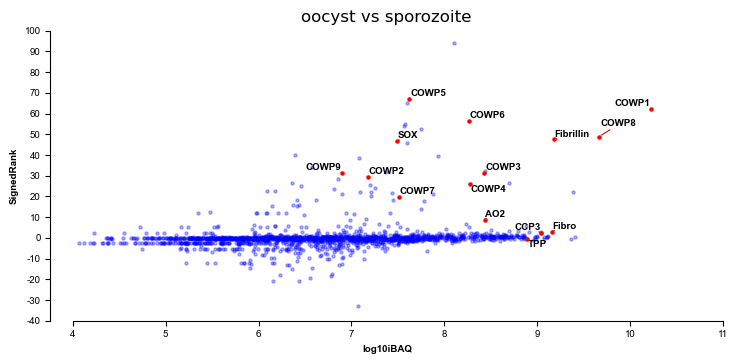

In [55]:
#ax.spines['left'].set_bounds(ymin+small_add, ymax)

#xmin, xmax = ax.get_xlim()
#ax.set_xlim(xmin,xmax)

#ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
fontProperties = {'family':'Arial',
    'weight' : 'normal', 'size' : 7}
fontProperties_names = {'family':'Arial',
    'weight' : 'bold', 'size' : 7}

plt.style.use('fivethirtyeight')
plt.style.use('default')



fig, axes=plt.subplots(figsize=(7.48,3.74), 
                     ncols=1, nrows=1)

#ids = df[df['Gene_id'].isin(['Tb927.11.11750','Tb927.3.2610'])]

_ids = list(name_dict.keys())
print(_ids)
#_names = viz.loc[_ids]['desc'] 
_names = [name_dict[n] for n in _ids]
#[['Gene_id']].values#['Tb927.11.11750']#ids['desc2'].values
#_names = [n[0] for n in _names]
print(_names)
#print(len(_ids))
#print(len(_names))
ax=axes
PTUT.make_vulcano(out_all, ax, x='log_sum', y='srank', 
             annot_index=_ids,
             annot_names = _names,
             title='',
             #fc_limit=70,
             fc_col='srank',
                  alpha_main=0.3,
             point_size_selection=5,
             point_size_all=5,
            text_size=7,
                  fontdict=fontProperties_names
            )

ax.set_title('oocyst vs sporozoite')
ax.set_xlabel('log10iBAQ',fontdict=fontProperties_names)
ax.set_ylabel('SignedRank',fontdict=fontProperties_names)
#ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9),
#          title='Legend')
#ax.yaxis.label.set_size(18)
#ax.xaxis.label.set_size(18)
#ax.title.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=7)





temp_xticks=[round(n,1) for n in np.arange(4, 12, 1)]
#print(temp_xticks)
ax.set_xticks(temp_xticks)
ax.set_xticklabels(temp_xticks, fontProperties)


temp_yticks=[round(n,1) for n in np.arange(-40, 110, 10)]

ax.set_yticks(temp_yticks)
ax.set_yticklabels(temp_yticks, fontProperties)






ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
xmin, xmax = ax.get_xlim()
print(xmin, xmax)
ax.spines['bottom'].set_bounds(4, 11)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(-40, 100)
ax.get_legend().remove()



plt.tight_layout()
plt.savefig('../out_data/FigX.svg')

plt.savefig('../out_data/FigX.png')
plt.show()


## 1) COWPs  MA

['cgd6_2090-RA-p1', 'cgd7_1800-RA-p1', 'cgd4_670-RA-p1', 'cgd8_3350-RA-p1', 'cgd7_5150-RA-p1', 'cgd4_3090-RA-p1', 'cgd4_500-RA-p1', 'cgd6_200-RA-p1', 'cgd6_210-RA-p1']
['COWP1', 'COWP2', 'COWP3', 'COWP4', 'COWP5', 'COWP6', 'COWP7', 'COWP8', 'COWP9']
no selection


No handles with labels found to put in legend.


3.759791999262934 11.0


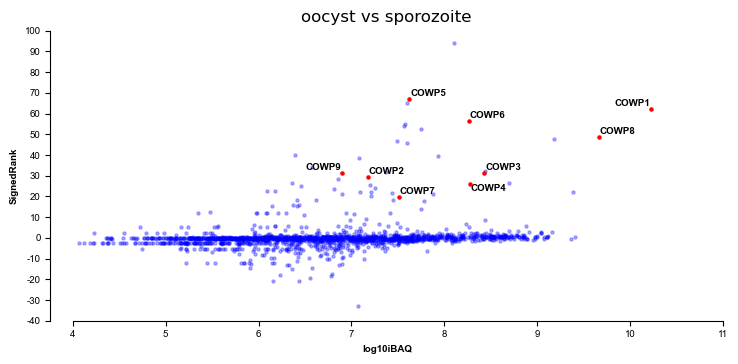

In [56]:
#the protein that have been localized
name_dict = {
'cgd6_2090-RA-p1':'COWP1',
'cgd7_1800-RA-p1':'COWP2',
'cgd4_670-RA-p1':'COWP3',
'cgd8_3350-RA-p1':'COWP4',
'cgd7_5150-RA-p1':'COWP5',
'cgd4_3090-RA-p1':'COWP6',
'cgd4_500-RA-p1':'COWP7',
'cgd6_200-RA-p1':'COWP8',
'cgd6_210-RA-p1':'COWP9',
#'cgd8_4830-RA-p1':'Kazal', 
     
}

#ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
fontProperties = {'family':'Arial',
    'weight' : 'normal', 'size' : 7}
fontProperties_names = {'family':'Arial',
    'weight' : 'bold', 'size' : 7}

plt.style.use('fivethirtyeight')
plt.style.use('default')



fig, axes=plt.subplots(figsize=(7.48,3.74), 
                     ncols=1, nrows=1)

#ids = df[df['Gene_id'].isin(['Tb927.11.11750','Tb927.3.2610'])]

_ids = list(name_dict.keys())
print(_ids)
#_names = viz.loc[_ids]['desc'] 
_names = [name_dict[n] for n in _ids]
#[['Gene_id']].values#['Tb927.11.11750']#ids['desc2'].values
#_names = [n[0] for n in _names]
print(_names)
#print(len(_ids))
#print(len(_names))
ax=axes
PTUT.make_vulcano(out_all, ax, x='log_sum', y='srank', 
             annot_index=_ids,
             annot_names = _names,
             title='',
             #fc_limit=70,
             fc_col='srank',
                  alpha_main=0.3,
             point_size_selection=5,
             point_size_all=5,
            text_size=7,
                  fontdict=fontProperties_names
            )

ax.set_title('oocyst vs sporozoite')
ax.set_xlabel('log10iBAQ',fontdict=fontProperties_names)
ax.set_ylabel('SignedRank',fontdict=fontProperties_names)
#ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9),
#          title='Legend')
#ax.yaxis.label.set_size(18)
#ax.xaxis.label.set_size(18)
#ax.title.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=7)





temp_xticks=[round(n,1) for n in np.arange(4, 12, 1)]
#print(temp_xticks)
ax.set_xticks(temp_xticks)
ax.set_xticklabels(temp_xticks, fontProperties)


temp_yticks=[round(n,1) for n in np.arange(-40, 110, 10)]

ax.set_yticks(temp_yticks)
ax.set_yticklabels(temp_yticks, fontProperties)






ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
xmin, xmax = ax.get_xlim()
print(xmin, xmax)
ax.spines['bottom'].set_bounds(4, 11)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(-40, 100)
ax.get_legend().remove()



plt.tight_layout()
plt.savefig('../out_data/FigX1A.svg')

plt.savefig('../out_data/FigX1A.png')
plt.show()


## 1) COWPs  Volcano

['cgd6_2090-RA-p1', 'cgd7_1800-RA-p1', 'cgd4_670-RA-p1', 'cgd8_3350-RA-p1', 'cgd7_5150-RA-p1', 'cgd4_3090-RA-p1', 'cgd4_500-RA-p1', 'cgd6_200-RA-p1', 'cgd6_210-RA-p1']
['COWP1', 'COWP2', 'COWP3', 'COWP4', 'COWP5', 'COWP6', 'COWP7', 'COWP8', 'COWP9']
no selection


No handles with labels found to put in legend.


[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2]
-50.0 100.19728614999998


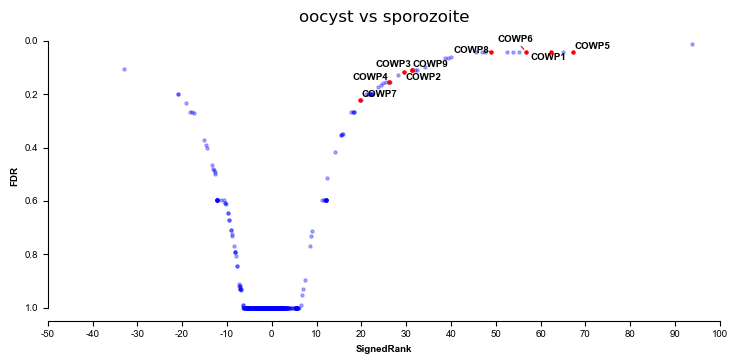

In [58]:
out_all['negFDR']=out_all['FDR']*-1
#the protein that have been localized
name_dict = {
'cgd6_2090-RA-p1':'COWP1',
'cgd7_1800-RA-p1':'COWP2',
'cgd4_670-RA-p1':'COWP3',
'cgd8_3350-RA-p1':'COWP4',
'cgd7_5150-RA-p1':'COWP5',
'cgd4_3090-RA-p1':'COWP6',
'cgd4_500-RA-p1':'COWP7',
'cgd6_200-RA-p1':'COWP8',
'cgd6_210-RA-p1':'COWP9',
#'cgd8_4830-RA-p1':'Kazal', 
     
}

#ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
fontProperties = {'family':'Arial',
    'weight' : 'normal', 'size' : 7}
fontProperties_names = {'family':'Arial',
    'weight' : 'bold', 'size' : 7}

plt.style.use('fivethirtyeight')
plt.style.use('default')



fig, axes=plt.subplots(figsize=(7.48,3.74), 
                     ncols=1, nrows=1)

#ids = df[df['Gene_id'].isin(['Tb927.11.11750','Tb927.3.2610'])]

_ids = list(name_dict.keys())
print(_ids)
#_names = viz.loc[_ids]['desc'] 
_names = [name_dict[n] for n in _ids]
#[['Gene_id']].values#['Tb927.11.11750']#ids['desc2'].values
#_names = [n[0] for n in _names]
print(_names)
#print(len(_ids))
#print(len(_names))
ax=axes
PTUT.make_vulcano(out_all, ax, x='srank', y='negFDR', 
             annot_index=_ids,
             annot_names = _names,
             title='',
             #fc_limit=70,
             fc_col='srank',
                  alpha_main=0.3,
             point_size_selection=5,
             point_size_all=5,
             text_size=7,
                  fontdict=fontProperties_names
            )

ax.set_title('oocyst vs sporozoite')
ax.set_xlabel('SignedRank',fontdict=fontProperties_names)
ax.set_ylabel('FDR',fontdict=fontProperties_names)
#ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9),
#          title='Legend')
#ax.yaxis.label.set_size(18)
#ax.xaxis.label.set_size(18)
#ax.title.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=7)





temp_xticks=[round(n,1) for n in np.arange(-50, 110, 10)]
print(temp_xticks)
ax.set_xticks(temp_xticks)
ax.set_xticklabels(temp_xticks, fontProperties)


print(ax.get_yticks())
#temp_yticks=[round(n,1) for n in np.arange(-40, 110, 10)]

#ax.set_yticks(temp_yticks)
ax.set_yticklabels([abs(round(n,1)) for n in ax.get_yticks()*-1], fontProperties)




ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
xmin, xmax = ax.get_xlim()
print(xmin, xmax)
ax.spines['bottom'].set_bounds(-50, 100)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(-1, 0)
ax.get_legend().remove()



plt.tight_layout()
plt.savefig('../out_data/FigX1B.svg')

plt.savefig('../out_data/FigX1B.png')
plt.show()


## 2) Signal peptide prediction (>60%)  MA

In [67]:
signalP = pd.read_csv('../in_data/CryptoDB-45_CparvumIowaII_AnnotatedProteins_summary.signalp5',
                      sep='\t',index_col=0)
signalP.head()
signalP = signalP[signalP.iloc[:,1]>0.6]
signalP = set(signalP.index.values)

,id,rank,FDR,sign,log_FDR,log_rank,srank,desc,log_sum,negFDR
cgd1_800-RA-p1,1,93.857207,0.01,+,1.962574,1.972468,93.857207,Protein disulfide isomerase,8.106946,-0.01
cgd7_5150-RA-p1,2,67.279057,0.04,+,1.388277,1.827880,67.279057,Chitin-binding type-2 domain containing protein,7.623759,-0.04
cgd6_4840-RA-p1,3,65.097189,0.04,+,1.388277,1.813562,65.097189,"Serine protease, subtilase family, signal peptide",7.598579,-0.04
cgd6_2090-RA-p1,4,62.289538,0.04,+,1.388277,1.794415,62.289538,Growth factor receptor cysteine-rich domain co...,10.226054,-0.04
cgd4_3090-RA-p1,5,56.644123,0.04,+,1.388277,1.753155,56.644123,Oocyst wall protein 6,8.266197,-0.04


No handles with labels found to put in legend.


no selection
3.759791999262934 11.0


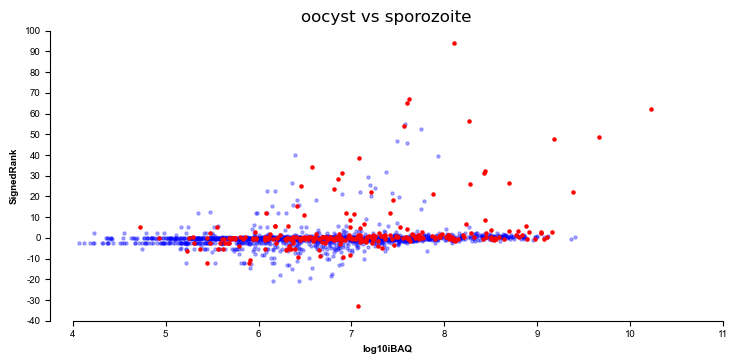

In [73]:
#the protein that have been localized


#ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
fontProperties = {'family':'Arial',
    'weight' : 'normal', 'size' : 7}
fontProperties_names = {'family':'Arial',
    'weight' : 'bold', 'size' : 7}

plt.style.use('fivethirtyeight')
plt.style.use('default')



fig, axes=plt.subplots(figsize=(7.48,3.74), 
                     ncols=1, nrows=1)

#ids = df[df['Gene_id'].isin(['Tb927.11.11750','Tb927.3.2610'])]

_ids = [n for n in out_all.index.values if n in signalP]
#print(_ids)
#_names = viz.loc[_ids]['desc'] 
_names = [name_dict.get(n,'none') for n in _ids]
#[['Gene_id']].values#['Tb927.11.11750']#ids['desc2'].values
#_names = [n[0] for n in _names]
#print(_names)
#print(len(_ids))
#print(len(_names))
ax=axes
PTUT.make_vulcano(out_all, ax, x='log_sum', y='srank', 
             annot_index=_ids,
             annot_names = _names,
             title='',
             #fc_limit=70,
             fc_col='srank',
                  alpha_main=0.3,
             point_size_selection=5,
             point_size_all=5,
            text_size=7,
                  fontdict=fontProperties_names,
                  add_text=False
            )

ax.set_title('oocyst vs sporozoite')
ax.set_xlabel('log10iBAQ',fontdict=fontProperties_names)
ax.set_ylabel('SignedRank',fontdict=fontProperties_names)
#ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9),
#          title='Legend')
#ax.yaxis.label.set_size(18)
#ax.xaxis.label.set_size(18)
#ax.title.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=7)





temp_xticks=[round(n,1) for n in np.arange(4, 12, 1)]
#print(temp_xticks)
ax.set_xticks(temp_xticks)
ax.set_xticklabels(temp_xticks, fontProperties)


temp_yticks=[round(n,1) for n in np.arange(-40, 110, 10)]

ax.set_yticks(temp_yticks)
ax.set_yticklabels(temp_yticks, fontProperties)






ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
xmin, xmax = ax.get_xlim()
print(xmin, xmax)
ax.spines['bottom'].set_bounds(4, 11)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(-40, 100)
ax.get_legend().remove()



plt.tight_layout()
plt.savefig('../out_data/FigX2A.svg')

plt.savefig('../out_data/FigX2A.png')
plt.show()



## 2) Signal peptide prediction (>60%)  Volcano

No handles with labels found to put in legend.


no selection
[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2]
-50.0 100.19728614999998


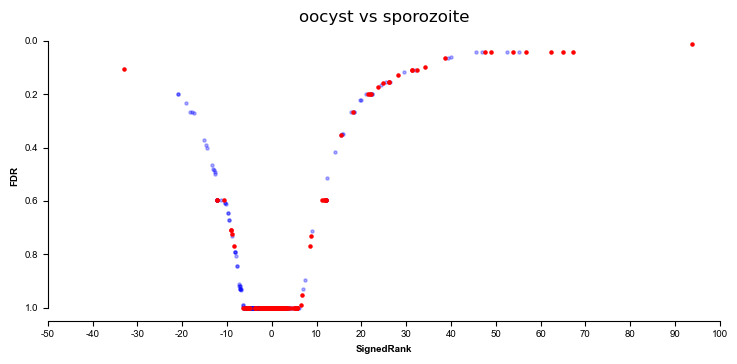

In [75]:
#ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
fontProperties = {'family':'Arial',
    'weight' : 'normal', 'size' : 7}
fontProperties_names = {'family':'Arial',
    'weight' : 'bold', 'size' : 7}

plt.style.use('fivethirtyeight')
plt.style.use('default')



fig, axes=plt.subplots(figsize=(7.48,3.74), 
                     ncols=1, nrows=1)

#ids = df[df['Gene_id'].isin(['Tb927.11.11750','Tb927.3.2610'])]

#_ids = list(name_dict.keys())
#print(_ids)
#_names = viz.loc[_ids]['desc'] 
#_names = [name_dict[n] for n in _ids]
#[['Gene_id']].values#['Tb927.11.11750']#ids['desc2'].values
#_names = [n[0] for n in _names]
#print(_names)
#print(len(_ids))
#print(len(_names))
ax=axes
PTUT.make_vulcano(out_all, ax, x='srank', y='negFDR', 
             annot_index=_ids,
             annot_names = _names,
             title='',
             #fc_limit=70,
             fc_col='srank',
                  alpha_main=0.3,
             point_size_selection=5,
             point_size_all=5,
             text_size=7,
                  fontdict=fontProperties_names,
                  add_text=False
            )

ax.set_title('oocyst vs sporozoite')
ax.set_xlabel('SignedRank',fontdict=fontProperties_names)
ax.set_ylabel('FDR',fontdict=fontProperties_names)
#ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9),
#          title='Legend')
#ax.yaxis.label.set_size(18)
#ax.xaxis.label.set_size(18)
#ax.title.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=7)





temp_xticks=[round(n,1) for n in np.arange(-50, 110, 10)]
print(temp_xticks)
ax.set_xticks(temp_xticks)
ax.set_xticklabels(temp_xticks, fontProperties)


print(ax.get_yticks())
#temp_yticks=[round(n,1) for n in np.arange(-40, 110, 10)]

#ax.set_yticks(temp_yticks)
ax.set_yticklabels([abs(round(n,1)) for n in ax.get_yticks()*-1], fontProperties)




ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
xmin, xmax = ax.get_xlim()
print(xmin, xmax)
ax.spines['bottom'].set_bounds(-50, 100)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(-1, 0)
ax.get_legend().remove()



plt.tight_layout()
plt.savefig('../out_data/FigX2B.svg')

plt.savefig('../out_data/FigX2B.png')
plt.show()


## 3) no transmembrane domain and signal peptide

In [87]:
phobius.head()

,TM,SP,PREDICTION
SEQENCE_ID,,,
cgd1_10-RA-p1,11,0,i20-43o63-83i104-125o145-172i219-242o248-269i2...
cgd1_100-RA-p1,0,0,o
cgd1_1000-RA-p1,0,0,o
cgd1_1010-RA-p1,0,0,o
cgd1_1023-RA-p1,0,0,o


In [110]:
phobius = pd.read_csv('../in_data/CryptoDB-45_CparvumIowaII_AnnotatedProteins.fasta.phobius.out',
                      index_col=0,delim_whitespace=True,header=0)
phobius['TM']=phobius['TM'].astype(int)
phobius = phobius[phobius['TM']<=0]
#phobius = set(phobius)
#len(phobius)
phobius['TM'].value_counts()
phobius = set(phobius.index.values)

No handles with labels found to put in legend.


201
(1659, 10)
no selection
3.759791999262934 11.0


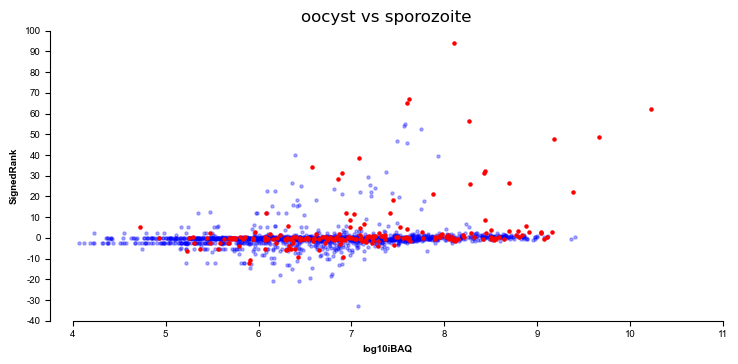

In [111]:
#the protein that have been localized


#ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
fontProperties = {'family':'Arial',
    'weight' : 'normal', 'size' : 7}
fontProperties_names = {'family':'Arial',
    'weight' : 'bold', 'size' : 7}

plt.style.use('fivethirtyeight')
plt.style.use('default')



fig, axes=plt.subplots(figsize=(7.48,3.74), 
                     ncols=1, nrows=1)

#ids = df[df['Gene_id'].isin(['Tb927.11.11750','Tb927.3.2610'])]

_ids = [n for n in out_all.index.values if n in phobius]
_ids = [n for n in _ids if n in signalP]
print(len(_ids))
print(out_all.shape)
#print(_ids)
#_names = viz.loc[_ids]['desc'] 
_names = [name_dict.get(n,'none') for n in _ids]
#[['Gene_id']].values#['Tb927.11.11750']#ids['desc2'].values
#_names = [n[0] for n in _names]
#print(_names)
#print(len(_ids))
#print(len(_names))
ax=axes
PTUT.make_vulcano(out_all, ax, x='log_sum', y='srank', 
             annot_index=_ids,
             annot_names = _names,
             title='',
             #fc_limit=70,
             fc_col='srank',
                  alpha_main=0.3,
             point_size_selection=5,
             point_size_all=5,
            text_size=7,
                  fontdict=fontProperties_names,
                  add_text=False
            )

ax.set_title('oocyst vs sporozoite')
ax.set_xlabel('log10iBAQ',fontdict=fontProperties_names)
ax.set_ylabel('SignedRank',fontdict=fontProperties_names)
#ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9),
#          title='Legend')
#ax.yaxis.label.set_size(18)
#ax.xaxis.label.set_size(18)
#ax.title.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=7)





temp_xticks=[round(n,1) for n in np.arange(4, 12, 1)]
#print(temp_xticks)
ax.set_xticks(temp_xticks)
ax.set_xticklabels(temp_xticks, fontProperties)


temp_yticks=[round(n,1) for n in np.arange(-40, 110, 10)]

ax.set_yticks(temp_yticks)
ax.set_yticklabels(temp_yticks, fontProperties)






ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
xmin, xmax = ax.get_xlim()
print(xmin, xmax)
ax.spines['bottom'].set_bounds(4, 11)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(-40, 100)
ax.get_legend().remove()



plt.tight_layout()
plt.savefig('../out_data/FigX3A.svg')

plt.savefig('../out_data/FigX3A.png')
plt.show()



## 3) no transmembrane domain and signal peptide Volcano

No handles with labels found to put in legend.


no selection
[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2]
-50.0 100.19728614999998


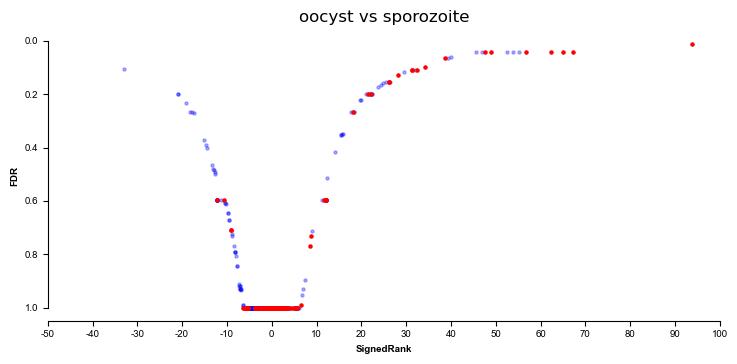

In [112]:
#ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
fontProperties = {'family':'Arial',
    'weight' : 'normal', 'size' : 7}
fontProperties_names = {'family':'Arial',
    'weight' : 'bold', 'size' : 7}

plt.style.use('fivethirtyeight')
plt.style.use('default')



fig, axes=plt.subplots(figsize=(7.48,3.74), 
                     ncols=1, nrows=1)

#ids = df[df['Gene_id'].isin(['Tb927.11.11750','Tb927.3.2610'])]

#_ids = list(name_dict.keys())
#print(_ids)
#_names = viz.loc[_ids]['desc'] 
#_names = [name_dict[n] for n in _ids]
#[['Gene_id']].values#['Tb927.11.11750']#ids['desc2'].values
#_names = [n[0] for n in _names]
#print(_names)
#print(len(_ids))
#print(len(_names))
ax=axes
PTUT.make_vulcano(out_all, ax, x='srank', y='negFDR', 
             annot_index=_ids,
             annot_names = _names,
             title='',
             #fc_limit=70,
             fc_col='srank',
                  alpha_main=0.3,
             point_size_selection=5,
             point_size_all=5,
             text_size=7,
                  fontdict=fontProperties_names,
                  add_text=False
            )

ax.set_title('oocyst vs sporozoite')
ax.set_xlabel('SignedRank',fontdict=fontProperties_names)
ax.set_ylabel('FDR',fontdict=fontProperties_names)
#ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9),
#          title='Legend')
#ax.yaxis.label.set_size(18)
#ax.xaxis.label.set_size(18)
#ax.title.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=7)





temp_xticks=[round(n,1) for n in np.arange(-50, 110, 10)]
print(temp_xticks)
ax.set_xticks(temp_xticks)
ax.set_xticklabels(temp_xticks, fontProperties)


print(ax.get_yticks())
#temp_yticks=[round(n,1) for n in np.arange(-40, 110, 10)]

#ax.set_yticks(temp_yticks)
ax.set_yticklabels([abs(round(n,1)) for n in ax.get_yticks()*-1], fontProperties)




ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
xmin, xmax = ax.get_xlim()
print(xmin, xmax)
ax.spines['bottom'].set_bounds(-50, 100)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(-1, 0)
ax.get_legend().remove()



plt.tight_layout()
plt.savefig('../out_data/FigX3B.svg')

plt.savefig('../out_data/FigX3B.png')
plt.show()


## MA plot interactive

In [48]:
import plotly.express as px
from plotly.subplots import make_subplots



fig1 = px.scatter(out_all, x='log_sum', y='srank', #color="log_FDR",
                 #title='PIGA interacting partners',
                 width=800, height=600,
                 hover_name=out_all.index.values, hover_data=["desc"],
                 #color_continuous_scale='Bluered',#px.colors.sequential.Viridis,
                )





trace1 = fig1['data'][0]

fig = make_subplots(rows=1, cols=2, shared_xaxes=False,shared_yaxes=False)
fig.add_trace(trace1, row=1, col=1)

fig.layout["xaxis"].title.text = "log10iBAQ"
fig.layout["yaxis"].title.text = "SignedRank"
fig.update_layout(title_text='Oocyst vs Sporozoite')
#fig.show()
fig.write_html("../out_data/oocyst_vs_sporozoite.html")


In [49]:
from IPython.display import IFrame
IFrame("../out_data/oocyst_vs_sporozoite.html", width=2000, height=600)

## Add External Features
- transmembrane domains
- signal peptides

In [114]:
signalP = pd.read_csv('../in_data/CryptoDB-45_CparvumIowaII_AnnotatedProteins_summary.signalp5',sep='\t',index_col=0)
final = out_all.join(signalP)

In [115]:
phobius = pd.read_csv('../in_data/CryptoDB-45_CparvumIowaII_AnnotatedProteins.fasta.phobius.out',
                      index_col=0,delim_whitespace=True,header=0)
#phobius.columns = ['TM','']
#phobius.head()

In [116]:
final = final.join(phobius)

In [117]:
my_selct = final.sort_values('srank',ascending=False)[
    ['srank','FDR','desc','SP(Sec/SPI)','TM','PREDICTION']].head(100)
my_selct.head()

,srank,FDR,desc,SP(Sec/SPI),TM,PREDICTION
cgd1_800-RA-p1,93.857207,0.01,Protein disulfide isomerase,0.752807,0,n4-15c22/23o
cgd7_5150-RA-p1,67.279057,0.04,Chitin-binding type-2 domain containing protein,0.985015,0,n7-18c23/24o
cgd6_4840-RA-p1,65.097189,0.04,"Serine protease, subtilase family, signal peptide",0.744158,0,n9-17c23/24o
cgd6_2090-RA-p1,62.289538,0.04,Growth factor receptor cysteine-rich domain co...,0.994961,0,n4-11c15/16o
cgd4_3090-RA-p1,56.644123,0.04,Oocyst wall protein 6,0.999096,0,n4-15c22/23o


In [118]:
#for n in [n.replace('-RA-p1','') for n in final.sort_values('srank',ascending=False).index.values][0:100]:
#    print(n)

In [119]:

#tag ='Intensity'
tag ='iBAQ'
#tag ='LFQ intensity'
def plot_prot(gene,log=True,tag='LFQ intensity',desc_dict={}):
    plt.style.use('ggplot')
    cols=[' SPORO_1',' SPORO_2',' SPORO_3', ' WALL_1', ' WALL_2',' WALL_3']
    cols = [tag+n for n in cols]
    temp = df[df['Fasta headers'].str.contains(gene)][cols]
    temp.columns = [n.split(' ')[-1] for  n in temp.columns]
    if log:
        temp=np.log10(temp)
    fig,ax=plt.subplots(figsize=(6,2))
    sns.barplot(data=temp,palette=palette,ax=ax)#.plot(kind='bar',color=palette)
    plt.ylabel(tag)
    plt.title(gene.replace('-RA-p1','') +': '+desc_dict.get(gene,'none'))
    #plt.xticks(rotation=45,ha='right')
    plt.tight_layout()
    plt.savefig('../out_data/'+gene+'.png')
    
    plt.show()
    #print(desc_dict[gene])
    #print(temp_PolySTest.loc[gene][['log2fc','log10meanInt']])


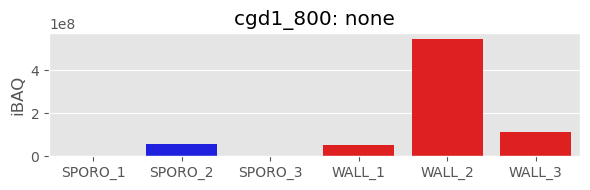

In [121]:
for protein in _ids:
    plot_prot(protein,tag ='iBAQ',log=False,desc_dict=name_dict)
    break

In [122]:
list(selection.columns)

['SPORO_1', 'SPORO_2', 'SPORO_3', 'WALL_1', 'WALL_2', 'WALL_3']

## Save data for webapp

In [123]:
temp = pd.DataFrame()
temp['Gene_id']=final.index.values
temp['Gene_id'] = [n.replace('-RA-p1','') for n in temp['Gene_id']]
temp['Gene_acc']=range(1,final.shape[0]+1)
temp['SignedRank']=final['srank'].values
temp['log10iBAQ']=final['log_sum'].values
temp['FDR']=final['FDR'].values
temp['Desc']=final['desc'].values
temp[['Gene_acc','Gene_id','SignedRank',
       'log10iBAQ','FDR','Desc']].to_csv('../webapp/indata.csv',index=False,)
temp.head()

,Gene_id,Gene_acc,SignedRank,log10iBAQ,FDR,Desc
0,cgd1_800,1,93.857207,8.106946,0.01,Protein disulfide isomerase
1,cgd7_5150,2,67.279057,7.623759,0.04,Chitin-binding type-2 domain containing protein
2,cgd6_4840,3,65.097189,7.598579,0.04,"Serine protease, subtilase family, signal peptide"
3,cgd6_2090,4,62.289538,10.226054,0.04,Growth factor receptor cysteine-rich domain co...
4,cgd4_3090,5,56.644123,8.266197,0.04,Oocyst wall protein 6


## Add InParanoid info

In [37]:
import xml.etree.ElementTree as ET
t_gondii = ET.parse('../InParanoid.C.parvum-T.gondii/C.parvum-T.gondii.orthoXML.xml').getroot()
p_falciparum = ET.parse('../InParanoid.C.parvum-P.falciparum/C.parvum-P.falciparum.orthoXML.xml').getroot()
n_caninum = ET.parse('../InParanoid.C.parvum-N.caninum/C.parvum-N.caninum.orthoXML.xml').getroot()

In [38]:
t_gondii_ortho = []
for species in t_gondii:
    print(species.tag, species.attrib)
    if  ( (species.tag == '{http://orthoXML.org/2011/}species')
    and (species.attrib['name'] == 'Cryptosporidium parvum ') ):
        for database in species:
            for genes in database:
                for gene in genes:
                    if gene.tag =='{http://orthoXML.org/2011/}gene':
                        #print(gene.tag, gene.attrib['geneId'])
                        t_gondii_ortho.append(gene.attrib['geneId'])

print(len(t_gondii_ortho))
t_gondii_ortho[0:5]
t_gondii_ortho = set(t_gondii_ortho)

{http://orthoXML.org/2011/}notes {}
{http://orthoXML.org/2011/}species {'name': 'Cryptosporidium parvum ', 'NCBITaxId': '353152'}
{http://orthoXML.org/2011/}species {'name': 'Toxoplasma gondii ', 'NCBITaxId': '5811'}
{http://orthoXML.org/2011/}scores {}
{http://orthoXML.org/2011/}groups {}
1321


In [39]:
p_falciparum_ortho = []
for species in p_falciparum:
    print(species.tag, species.attrib)
    if  ( (species.tag == '{http://orthoXML.org/2011/}species')
    and (species.attrib['name'] == 'Cryptosporidium parvum ') ):
        for database in species:
            #print(database.tag, database.attrib)
            for genes in database:
                #print('genes',genes.tag, genes.attrib)
                for gene in genes:
                    #print('genes',gene.tag, gene.attrib)
                    if gene.tag =='{http://orthoXML.org/2011/}gene':
                        #print(gene.tag, gene.attrib['geneId'])
                        p_falciparum_ortho.append(gene.attrib['geneId'])

print(len(p_falciparum_ortho))
p_falciparum_ortho[0:5]
p_falciparum_ortho = set(p_falciparum_ortho)

{http://orthoXML.org/2011/}notes {}
{http://orthoXML.org/2011/}species {'name': 'Cryptosporidium parvum ', 'NCBITaxId': '353152'}
{http://orthoXML.org/2011/}species {'name': 'Plasmodium falciparum (isolate 3D7) ', 'NCBITaxId': '36329'}
{http://orthoXML.org/2011/}scores {}
{http://orthoXML.org/2011/}groups {}
1413


In [40]:
n_caninum_ortho = []
for species in n_caninum:
    print(species.tag, species.attrib)
    if  ( (species.tag == '{http://orthoXML.org/2011/}species')
    and (species.attrib['name'] == 'Cryptosporidium parvum ') ):
        for database in species:
            #print(database.tag, database.attrib)
            for genes in database:
                #print('genes',genes.tag, genes.attrib)
                for gene in genes:
                    #print('genes',gene.tag, gene.attrib)
                    if gene.tag =='{http://orthoXML.org/2011/}gene':
                        #print(gene.tag, gene.attrib['geneId'])
                        n_caninum_ortho.append(gene.attrib['geneId'])

print(len(n_caninum_ortho))
n_caninum_ortho[0:5]
n_caninum_ortho = set(n_caninum_ortho)

{http://orthoXML.org/2011/}notes {}
{http://orthoXML.org/2011/}species {'name': 'Cryptosporidium parvum ', 'NCBITaxId': '353152'}
{http://orthoXML.org/2011/}species {'name': 'Neospora caninum ', 'NCBITaxId': '572307'}
{http://orthoXML.org/2011/}scores {}
{http://orthoXML.org/2011/}groups {}
1403


In [41]:
final['t_gondii_ortho'] = [True if n.replace('-RA-p1','') 
                           in t_gondii_ortho else False for n in final.index.values]
final['p_falciparum_ortho'] = [True if n.replace('-RA-p1','')
                               in p_falciparum_ortho else False for n in final.index.values]
final['n_caninum_ortho'] = [True if n.replace('-RA-p1','')
                               in n_caninum_ortho else False for n in final.index.values]

In [42]:
final['t_gondii_ortho'].value_counts()

False    857
True     802
Name: t_gondii_ortho, dtype: int64

In [43]:
final['p_falciparum_ortho'].value_counts()

False    865
True     794
Name: p_falciparum_ortho, dtype: int64

In [44]:
final['n_caninum_ortho'].value_counts()

True     836
False    823
Name: n_caninum_ortho, dtype: int64

In [45]:
selection = final[(final['srank']>5) & final['t_gondii_ortho'] & ~final['p_falciparum_ortho']]
selection[['desc','srank']]

,desc,srank
cgd7_5150-RA-p1,Chitin-binding type-2 domain containing protein,67.279057
cgd6_4840-RA-p1,"Serine protease, subtilase family, signal peptide",65.097189
cgd4_3090-RA-p1,Oocyst wall protein 6,56.644123
cgd7_4560-RA-p1,Sushi/SCR/CCP/SbsA/lg-like domain containing p...,53.858537
cgd7_850-RA-p1,Patched family protein/Sterol-sensing domain-c...,52.503351
cgd2_2510-RA-p1,Glucose-methanol-choline oxidoreductase,34.095415
cgd4_500-RA-p1,Oocyst wall protein 7,19.737609
cgd4_3550-RA-p1,Secreted Kazal domain-containing protein,11.857639
cgd5_3420-RA-p1,TSP1/LNR (Lin-12/Notch) repeat containing protein,11.149744
cgd3_3430-RA-p1,Amine oxidase,8.824921


In [46]:
selection = final[(final['srank']>5) 
                  & (final['t_gondii_ortho'] | final['n_caninum_ortho']) 
                  & ~final['p_falciparum_ortho']]
selection[['desc','srank',
           't_gondii_ortho','n_caninum_ortho','p_falciparum_ortho',
          'SP(Sec/SPI)','TM']].to_csv('../out_data/ortho_analysis.csv')

## Save dataset and nootebook

In [47]:
#save finala dataset
final.to_csv('../out_data/final_df.csv')

In [124]:
!jupyter nbconvert --to html_toc analysis.ipynb

[NbConvertApp] Converting notebook analysis.ipynb to html_toc
[NbConvertApp] Support files will be in analysis_files/
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Making directory analysis_files
[NbConvertApp] Writing 489045 bytes to analysis.html
